In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from matplotlib import image
from pathlib import Path
from tensorflow.keras import models, layers, Model, Input

from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, UpSampling2D, MaxPooling2D, concatenate

from PIL import Image
from numpy import asarray

In [2]:
isic_input_path = './../../../dataset/ISIC2018_Task1-2_Training_Input_x2/*.jpg'
isic_groundTruth_path = './../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2/*.png'

In [3]:
isic_input = sorted(glob.glob(isic_input_path))
isic_groundTruth = sorted(glob.glob(isic_groundTruth_path))

DATASET_SIZE = len(isic_input)
BATCH_SIZE = 8
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 4

In [4]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

In [5]:
## Splitting up the dataset for training, validation, and testing

full_ds = tf.data.Dataset.from_tensor_slices((isic_input, isic_groundTruth))
full_ds = full_ds.shuffle(DATASET_SIZE, reshuffle_each_iteration=False)

train_ds = full_ds.take(train_size)

# skip the dataset for train
test_ds = full_ds.skip(train_size)

val_ds = full_ds.skip(val_size)
test_ds = full_ds.take(test_size)

In [6]:
# for image, label in train_ds.take(5):
#     print('Image file:', image.numpy())
#     print('Label:', label.numpy())

In [7]:
# def get_palette(a_input):
#     sample = cv2.cvtColor(cv2.imread((a_input)), cv2.COLOR_RGB2RGBA)
#     print(sample.shape)
#     sample = cv2.resize(sample, (256,256))
#     # print(test.shape)
#     # print(test)

#     my_list= []
#     for i in range(sample.shape[0]):
#         for j in range(sample.shape[1]):
#             my_list.append(sample[i,j,:].tolist())
    
#     palette = sort_and_deduplicate(my_list)
#     # print(palette)
#     return palette

# def uniq(lst):
#     last = object()
#     for item in lst:
#         if item == last:
#             continue
#         yield item
#         last = item

# def sort_and_deduplicate(l):
#     return list(uniq(sorted(l, reverse=True)))


# palette = get_palette(isic_groundTruth[0])
# palette2 = get_palette(isic_groundTruth[1])
# palette = [[255, 255, 255, 255], [0, 0, 0, 255]]
# palette = [0, 255]
# print(len(palette))

# sample3 = tf.io.read_file(isic_input[0])
# sample3 = tf.image.decode_png(sample3, channels=3) / 255
# print(sample3)

tf.Tensor(
[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]], shape=(256, 256, 1), dtype=uint8)
./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\ISIC_0000000_segmentation.png


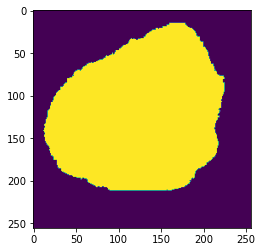

In [8]:
# sample2 = cv2.cvtColor(cv2.imread((isic_groundTruth[0])), cv2.COLOR_RGB2RGBA)
sample2 = tf.io.read_file(isic_groundTruth[0])
sample2 = tf.image.decode_png(sample2, channels=1)

sample2 =  tf.image.resize(sample2, [IMG_WIDTH, IMG_HEIGHT])
# gray_image = tf.squeeze(sample2) # shape (127,127,1) -> shape (127,127)
select_op = tf.where(sample2>127, 255*tf.ones_like(sample2), tf.zeros_like(sample2))
select_op = tf.reshape(select_op, (256, 256, 1)) / 255
# select_op = tf.cast(select_op, tf.float32) / 255
select_op = tf.cast(select_op, tf.uint8)
# print(np.unique(select_op))
print(select_op)
print(isic_groundTruth[0])
plt.imshow(select_op)

# sample2 =  tf.image.resize(sample2, [IMG_WIDTH, IMG_HEIGHT])
# print(sample2.shape)

# # for i in sample2:
# #     for j in i:
# #         print(j)
# unique = np.unique(sample2)
# print(unique)

In [9]:
def decode_img(image):
    image = tf.image.decode_jpeg(image, channels=3)
    # resize the image 256*256 
    image =  tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    # Standardise values to be in the [0, 1] range.
    image = tf.cast(image, tf.float32) / 255.0
    
    return image
    
def decode_label(label):
    label = tf.image.decode_png(label, channels=1)
    # Resize the image to the desired size.
    label =  tf.image.resize(label, [IMG_WIDTH, IMG_HEIGHT])
    label = tf.where(label > 127, 255*tf.ones_like(label), tf.zeros_like(label))

#     label = tf.reshape(label, (IMG_WIDTH, IMG_HEIGHT, 1)) / 255
#     label = tf.cast(label, tf.float32)
#     return label
    
    one_hot_map = []

    for clr in [0, 255]:
        class_map = tf.equal(label, clr)
        class_map = tf.reduce_all(class_map,axis=-1)
        one_hot_map.append(class_map)
    
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)
    return one_hot_map

    
def process_data(image, label):
    image = tf.io.read_file(image)
    image = decode_img(image)
    
    label = tf.io.read_file(label)
    label = decode_label(label)
    
    return image, label   

In [10]:
# Use Dataset.map to apply this transformation.
processed_train_ds = train_ds.map(process_data)
processed_val_ds = val_ds.map(process_data)
processed_test_ds = test_ds.map(process_data)

In [11]:
# for image, label in train_ds.take(1):
#     print('Image shape:', image.numpy())
#     print('Label:', label.numpy())
# print()

## Getting the output size
output_size = 0
for image, label in processed_train_ds.take(1):
    output_size = label.numpy().shape[2]
#     print('Image shape:', image.numpy().shape)
#     print('Label:', label.numpy().shape)
# plt.figure(figsize=(20, 10))

# print(output_size)

# print(label)
# plt.subplot(1, 4, 1)
# plt.imshow(image.numpy())
# plt.axis('off')

# plt.subplot(1, 4, 2)
# # plt.imshow(tf.argmax(label.numpy(), axis=2))
# plt.imshow(label.numpy())
# plt.axis('off')

In [18]:
from tensorflow.keras import backend as K

# def dice_coef(y_true, y_pred, smooth=1):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)

def dice_coef(y_true, y_pred, smooth=1):
#     y_true_f_0 = K.flatten(y_true[:,:,0])
#     y_pred_f_0 = K.flatten(y_pred[:,:,0])
#     intersection_0 = K.sum(y_true_f_0 * y_pred_f_0)
#     res_0 = (2. * intersection_0 + smooth) / (K.sum(y_true_f_0) + K.sum(y_pred_f_0) + smooth)
    
#     y_pred_f_1 = K.flatten(y_pred[:,:,1])
#     y_true_f_1 = K.flatten(y_true[:,:,1])
#     intersection_1 = K.sum(y_true_f_1 * y_pred_f_1)
#     res_1 = (2. * intersection_1 + smooth) / (K.sum(y_true_f_1) + K.sum(y_pred_f_1) + smooth)
    
#     total = (res_0 + res_1) / 2
#     return total
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef2(img, img2):
    if img.shape != img2.shape:
        print(img)
        print(img2.shape)
        raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
    else:
        img = img.numpy().astype(np.bool)
        img2 = img2 > 0.5
        intersection = np.logical_and(img, img2)
        value = (2. * intersection.sum())  / (img.sum() + img2.sum())
    return value 

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def display(image, ground_truth, prediction, num):
    plt.figure(figsize=(20, 20))
    colors = ['black', 'green', 'red']
    for i in range(num):
        plt.subplot(4, 3, 3*i+1)
        plt.imshow(image[i])
        title = plt.title('The actual image')
        plt.setp(title, color=colors[0])
        plt.axis('off')
        
        plt.subplot(4, 3, 3*i+2)
        plt.imshow(tf.argmax(ground_truth[i], axis=-1))
        title = plt.title('Ground truth image segmentation')
        plt.setp(title, color=colors[1])
        plt.axis('off')
        
        plt.subplot(4, 3, 3*i+3)
#         prediction_binary = tf.where(prediction[i] > 0.5, tf.ones_like(prediction[i]), tf.zeros_like(prediction[i]))
        plt.imshow(tf.argmax(prediction[i], axis=-1))
        title = plt.title('Prediction image segmentation')
        plt.setp(title, color=colors[2])
        plt.axis('off')

        print("DICE SIMILARITY FOR INPUT {}: {}".format(i, dice_coef(ground_truth[i], prediction[i])))
    plt.show()

    
def show_predictions(processed_test_ds, num=3):
    image_test_batch, label_test_batch = next(iter(processed_test_ds.batch(3)))
    prediction = model.predict(image_test_batch)
    display(image_test_batch, label_test_batch, prediction, num)

    
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(processed_test_ds)

In [19]:
from model import *

model = unet(output_size)

if (output_size > 2):
    print("Loss Function: categorical_crossentropy")
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy', dice_coef])
else:
    print("Loss Function: binary_crossentropy")
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy', dice_coef])

# print("Loss Function: dice similarity coefficient")
# model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])

print()
model.summary()

SIGMOID
Loss Function: dice similarity coefficient

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_39[0][0]                  
________________________________________

DICE SIMILARITY FOR INPUT 0: 0.6671000719070435
DICE SIMILARITY FOR INPUT 1: 0.6671000719070435
DICE SIMILARITY FOR INPUT 2: 0.6671000719070435


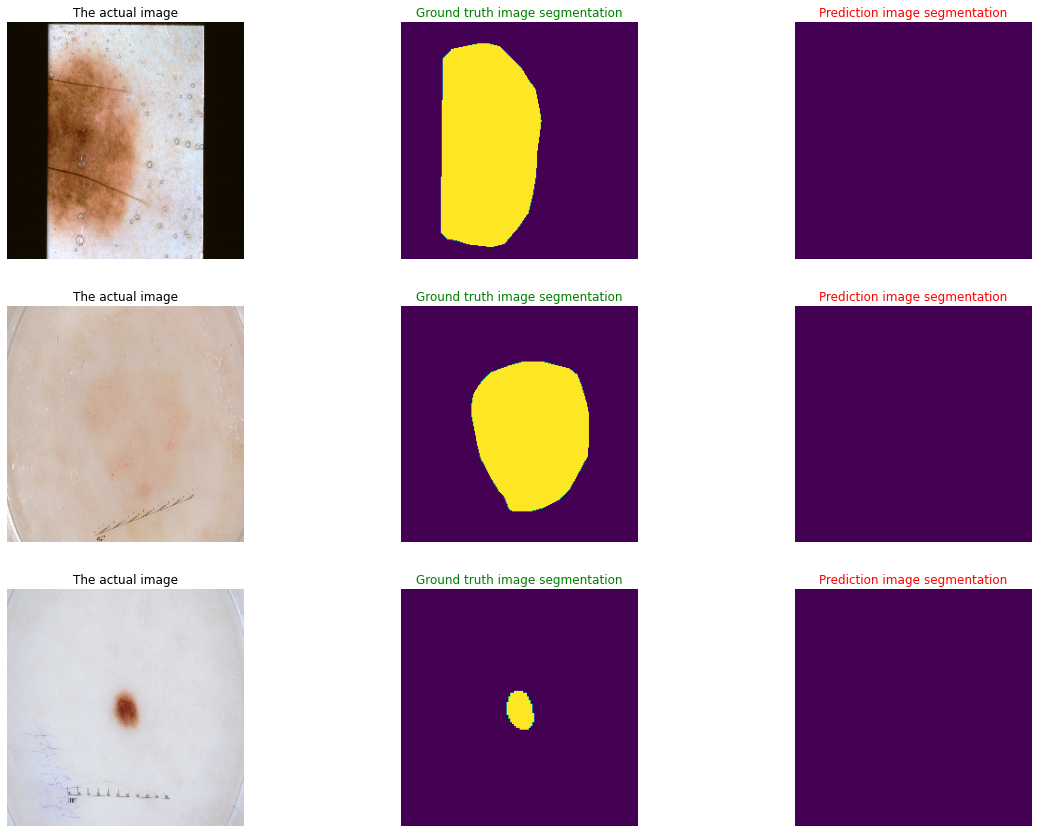

227/227 [==============================] - 165s 726ms/step - loss: 0.4138 - dice_coef: 0.5862 - val_loss: 0.4132 - val_dice_coef: 0.5868


In [20]:
history = model.fit(processed_train_ds.batch(BATCH_SIZE), 
                    validation_data=processed_val_ds.batch(BATCH_SIZE), 
                    epochs=5, callbacks=[DisplayCallback()])

In [ ]:
results = model.evaluate(processed_test_ds.batch(BATCH_SIZE), verbose=2)
print(results)

In [ ]:
image_test_batch, label_test_batch = next(iter(processed_test_ds.batch(3)))
prediction = model.predict(image_test_batch)

print(prediction.shape)
plt.imshow(tf.argmax(label_test_batch[2], axis=-1))

In [ ]:
plt.imshow(prediction[0][:,:,1])

In [ ]:
plt.imshow(tf.argmax(prediction[1] > 0.5, axis=-1))
print(dice_coef2(label_test_batch[1], prediction[1]))

In [ ]:
# show_predictions(processed_test_ds)

In [ ]:
################# HERE I USED SIGMOID INSTEAD OF SOFTMAX, INIT KERNEL IS 32